In [1]:
import etl
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [4]:
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from keras.utils import to_categorical

In [6]:
%%time
df = etl.load(files=["data/US_Accidents_March23.csv"])
df.shape

CPU times: total: 49.9 s
Wall time: 1min 7s


(233093, 14)

In [7]:
df.head()

,Distance(mi),Temperature(F),Wind_Speed(mph),Precipitation(in),Duration(min),Hour,Month,Crossing,Traffic_Signal,Is_Highway,Is_Weekend,Is_Night,Weather_Condition,Severity
87,0.01,14.0,11.5,0.0,30.000000,5,2,False,False,False,False,True,Winter Weather,3
91,0.01,17.1,21.9,0.0,871.000000,6,2,False,False,True,False,True,Cloudy,3
96,0.01,15.1,18.4,0.0,49.066667,7,2,False,False,True,False,False,Cloudy,3
150,0.00,21.0,11.5,0.0,30.000000,7,2,False,False,False,False,False,Winter Weather,2
235,0.01,19.0,5.8,0.0,30.000000,6,2,False,True,False,False,True,Clear,2


## Model Selection

In [8]:
def stratified_downsample(df, target_col, downsample_pct=0.2):
    _, downsampled_df = train_test_split(df, test_size=downsample_pct, stratify=df[target_col], random_state=42)
    return downsampled_df

In [9]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [10]:
def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.3f}, F1 Score: {f1:.3f}, Cohen's Kappa: {kappa:.3f}")

In [11]:
def plot_feat_importance(data):
    importances, feature_names = data
    # Plotting the feature importances
    plt.figure(figsize=(8, 5))
    plt.barh(feature_names, importances)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

In [12]:
def train_pipeline(clf, build_fn=None, data=None, files=None, ignore_vars=None, ordinal_feats=[], test_size=0.3, 
                   scoring='f1_weighted', grid_search=False, params=None, sampling_params=None, 
                   show_cm=True, include_importance=False, full_train=False, device='cpu'):
    # 1-Load Data
    if data is None and files is None:
        raise Exception("DataFrame or list of files expected.")
    elif files is not None:
        print("Importing data...")
        data = etl.load(files)
    
    # 2-Define preprocessing steps
    # Define features and target
    if "Severity" not in data.columns:
        raise ValueError("Column 'Severity' not found in the data.")
    
    X = data.drop(columns=["Severity"])
    y = data["Severity"]
    
    # Ignore certain columns
    if ignore_vars is None:
        ignore_vars = []
        
    X = X[[c for c in X.columns if c not in ignore_vars]]
    
    # Normalize numerical variables
    num_features = X.select_dtypes(include=['number']).columns.tolist()
    num_transformer = StandardScaler() if num_features else 'passthrough'
    
    # One-hot encode categorical variables
    cat_features = [c for c in X.select_dtypes(include=['object', 'category']).columns.tolist() if c not in ordinal_feats]
    cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore') if cat_features else 'passthrough'
    
    # Handle ordinal variables
    ord_features = [c for c in ordinal_feats if c in X.columns]
    ord_transformer = 'passthrough'
    
    # Handle boolean variables
    bool_features = X.select_dtypes(include=['bool']).columns.tolist()
    bool_transformer = 'passthrough'
    
    # Encode ordinal target
    target_transformer = OrdinalEncoder(categories=[[1, 2, 3, 4]])
    y = target_transformer.fit_transform(y.values.reshape(-1, 1)).ravel()  # Flatten the target array
    if clf == "mlp":
        n_classes = len(np.unique(y))
        # One-hot encode the target variable
        y = to_categorical(y, num_classes=n_classes)
    
    if sampling_params:
        print("Resampling with SMOTE..")
        # Add SMOTE oversampling to the pipeline
        smote_method = sampling_params.get('smote-method')
        sampling_strategy = sampling_params.get('sampling_strategy', 'auto')
        
        if smote_method:
            if type(sampling_strategy) is dict:
                sampling_strategy = {k: int(np.ceil(v*(1-test_size)*len(X))) for k,v in sampling_strategy.items()}
        
            if smote_method == 'class-wise':
                smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
            elif smote_method == 'borderline':
                smote = BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42)
            else:
                raise Exception(f"SMOTE method '{smote_method}' not supported")
        else:
            smote = 'passthrough'
        
        # Add Downsampling to the pipeline
        downsampling_strategy = sampling_params.get('downsampling_strategy')
        
        if downsampling_strategy:
            if type(downsampling_strategy) is dict:
                downsampling_strategy = {k: int(np.floor(v*(1-test_size)*len(X))) for k,v in downsampling_strategy.items()}
        
            downsampler = RandomUnderSampler(sampling_strategy=downsampling_strategy, random_state=42)
        else:
            downsampler = 'passthrough'
    else:
        smote = 'passthrough'
        downsampler = 'passthrough'
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_features),
            ('cat', cat_transformer, cat_features),
            ('ord', ord_transformer, ord_features),
            ('bool', bool_transformer, bool_features),
        ])
    
    # 3-Split data into train-test set
    if full_train:
        X_train = X
        y_train = y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    
    if clf == "mlp":
        # Fit the preprocessor on the training data to transform the features
        preprocessor.fit(X_train)
        X_train_transformed = preprocessor.transform(X_train)
        # Define MLP classifier
        model = KerasClassifier(model=build_fn, 
                              input_dim=X_train_transformed.shape[1],
                              output_dim=n_classes,
                              hid_dim=[64, 64],
                              learning_rate=0.001,
                              epochs=10, 
                              batch_size=32, 
                              dropout_rate=0.3, 
                              verbose=0)
    
    # 4-Train model
    model_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('downsampling', downsampler),
        ('clf', model)
    ])
    
    if grid_search and params:
        # Optional hyperparameter tuning
        grid_search_cv = GridSearchCV(model_pipeline, params, cv=5, scoring=scoring)
        print("Training model with GridSearchCV..")
        grid_search_cv.fit(X_train, y_train)
        # Use the best model from GridSearchCV
        model = grid_search_cv.best_estimator_
        print("Training completed..")
        # Print best hyperparameters
        print("Best hyperparameters:\n", grid_search_cv.best_params_)
    else:
        print("Training model..")
        model_pipeline.fit(X_train, y_train)
        model = model_pipeline
        print("Training completed..")
        
    # 5-Test model
    
    print("Model evaluation..")
    print("\nTrain metrics:")
    y_train_pred = model.predict(X_train)
    if clf == "mlp":
        y_train_pred = np.argmax(y_train_pred, axis=1)
        y_train = np.argmax(y_train, axis=1)
    print(clf == "mlp")
    evaluate(y_train, y_train_pred)
    
    if not full_train:
        print("\nTest metrics:")
        y_pred = model.predict(X_test)
        if clf == "mlp":
            y_pred = np.argmax(y_pred, axis=1)
            y_test = np.argmax(y_test, axis=1)
        evaluate(y_test, y_pred)
    
        print("\nClassification report:")
        print(classification_report(y_test, y_pred))
    
        if show_cm:
            print("\nConfusion matrix:")
            cm = confusion_matrix(y_test, y_pred, normalize='true')
            plot_confusion_matrix(cm)
    
        print("Evaluation completed..")
    
    # 6-Optional plot feature importance
    if include_importance and hasattr(model.named_steps['clf'], 'feature_importances_'):
        feature_names = num_features + bool_features + ord_features
        # Access the OneHotEncoder to get the feature names after fitting
        if isinstance(cat_transformer, OneHotEncoder):
            cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
            feature_names += list(cat_feature_names)   
        importances = model.named_steps['clf'].feature_importances_

        if include_importance and importances is not None:
            return model, (importances, feature_names)
    return model

### Decision Tree (Baseline)

In [13]:
dt_params = {
    'clf__criterion': ['entropy'],#['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30, 50],
    'clf__min_samples_split': [2, 5], #[2, 5, 10, 20],
    'clf__min_samples_leaf': [1, 5, 10, 15],
    'clf__max_features': [None, 'sqrt'],
    'clf__splitter': ['best', 'random'],
    'clf__random_state': [42],
    'clf__class_weight': ['balanced']
}

Training model with GridSearchCV..
Training completed..
Best hyperparameters:
 {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__random_state': 42, 'clf__splitter': 'best'}
Model evaluation..

Train metrics:
Accuracy: 0.998, F1 Score: 0.998, Cohen's Kappa: 0.996

Test metrics:
Accuracy: 0.725, F1 Score: 0.726, Cohen's Kappa: 0.408

Classification report:
              precision    recall  f1-score   support

         0.0       0.22      0.24      0.23       402
         1.0       0.80      0.80      0.80     46218
         2.0       0.61      0.60      0.61     22021
         3.0       0.20      0.21      0.20      1287

    accuracy                           0.73     69928
   macro avg       0.46      0.46      0.46     69928
weighted avg       0.73      0.73      0.73     69928


Confusion matrix:


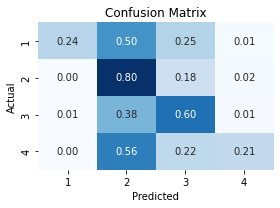

Evaluation completed..
CPU times: total: 4min 35s
Wall time: 5min 5s


In [14]:
%%time
_, feat_importance_dt0 = train_pipeline(clf=DecisionTreeClassifier(), data=df, ignore_vars=None, ordinal_feats=["Month"], 
                               test_size=0.3, scoring='f1_weighted', 
                               grid_search=True, params=dt_params,
                               show_cm=True, include_importance=True)

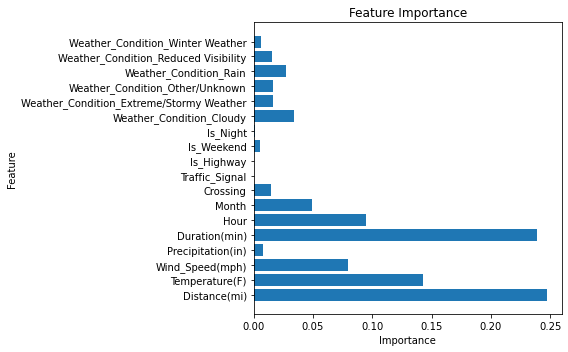

In [15]:
plot_feat_importance(feat_importance_dt0)

### XGBoost

In [74]:
xgb_params = {
    'clf__n_estimators': [100, 150, 200],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__max_depth': [3, 4, 5, 6, 10, 15],
    'clf__subsample': [0.6, 0.8, 1.0],
}

In [30]:
xgb_clf = xgb.XGBClassifier(device='cuda', tree_method='hist', use_label_encoder=False)

Training model with GridSearchCV..
Training completed..
Best hyperparameters:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Model evaluation..

Train metrics:
Accuracy: 0.889, F1 Score: 0.887, Cohen's Kappa: 0.754

Test metrics:
Accuracy: 0.802, F1 Score: 0.795, Cohen's Kappa: 0.557

Classification report:
              precision    recall  f1-score   support

         0.0       0.51      0.16      0.24       402
         1.0       0.84      0.88      0.86     46218
         2.0       0.73      0.69      0.71     22021
         3.0       0.55      0.11      0.18      1287

    accuracy                           0.80     69928
   macro avg       0.66      0.46      0.50     69928
weighted avg       0.79      0.80      0.79     69928


Confusion matrix:


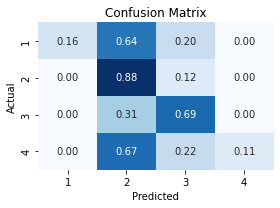

Evaluation completed..
CPU times: total: 28min 11s
Wall time: 23min 23s


In [31]:
%%time
_, feat_importance_xgb0 = train_pipeline(clf=xgb_clf, data=df, ignore_vars=None, ordinal_feats=["Month"], 
                                        test_size=0.3, scoring='f1_weighted', grid_search=True, params=xgb_params, 
                                        sampling_params=None, show_cm=True, include_importance=True)

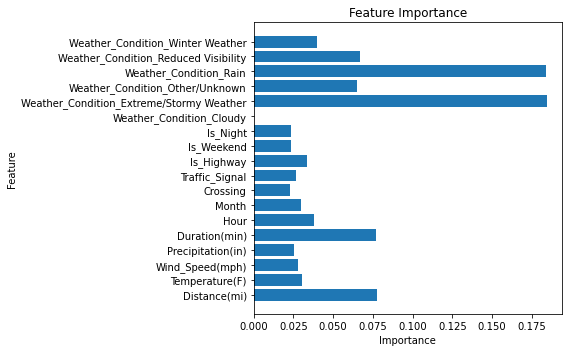

In [32]:
plot_feat_importance(feat_importance_xgb0)

#### Resampling
Considering the severe class imbalance in the dataset, we use SMOTE to oversample the minority classes. We may consider two approaches: Class-wise SMOTE and Borderline-SMOTE.

*Class-wise SMOTE:* Independently oversamples each minority class to a specified level. It is flexible and simple for multiclass imbalances but ay introduce noise by generating synthetic samples in overlapping regions.

In [57]:
# Class-wise SMOTE
sampling_params_xgb = {
    "smote-method": "class-wise",
    "sampling_strategy": {0: 0.15, 3: 0.15},
    "downsampling_strategy": {1: 0.5}
}

Resampling with SMOTE..
Training model with GridSearchCV..
Training completed..
Best hyperparameters:
 {'clf__learning_rate': 0.2, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Model evaluation..

Train metrics:
Accuracy: 0.907, F1 Score: 0.908, Cohen's Kappa: 0.803

Test metrics:
Accuracy: 0.795, F1 Score: 0.794, Cohen's Kappa: 0.561

Classification report:
              precision    recall  f1-score   support

         0.0       0.27      0.29      0.28       402
         1.0       0.86      0.84      0.85     46218
         2.0       0.69      0.75      0.72     22021
         3.0       0.42      0.20      0.27      1287

    accuracy                           0.80     69928
   macro avg       0.56      0.52      0.53     69928
weighted avg       0.80      0.80      0.79     69928


Confusion matrix:


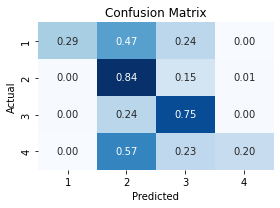

Evaluation completed..
CPU times: total: 38min 21s
Wall time: 31min 49s


In [34]:
%%time
_, feat_importance_xgb1 = train_pipeline(clf=xgb_clf, data=df, ignore_vars=None, ordinal_feats=["Month"], 
                                        test_size=0.3, scoring='f1_weighted', grid_search=True, params=xgb_params, 
                                        sampling_params=sampling_params_xgb, show_cm=True, include_importance=True)

*Borderline-SMOTE:* Focuses on oversampling near the decision boundary to improve classification in difficult areas. It improves performance by targeting challenging instances but also relies on identifying borderline instances, which can be complex.

In [58]:
# Borderline-SMOTE
sampling_params_xgb = {
    "smote-method": "borderline",
    "sampling_strategy": {0: 0.15, 3: 0.15},
    "downsampling_strategy": {1: 0.5}
}

Resampling with SMOTE..
Training model with GridSearchCV..
Training completed..
Best hyperparameters:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Model evaluation..

Train metrics:
Accuracy: 0.865, F1 Score: 0.866, Cohen's Kappa: 0.714

Test metrics:
Accuracy: 0.794, F1 Score: 0.794, Cohen's Kappa: 0.561

Classification report:
              precision    recall  f1-score   support

         0.0       0.24      0.36      0.29       402
         1.0       0.86      0.84      0.85     46218
         2.0       0.69      0.75      0.72     22021
         3.0       0.38      0.21      0.27      1287

    accuracy                           0.79     69928
   macro avg       0.54      0.54      0.53     69928
weighted avg       0.80      0.79      0.79     69928


Confusion matrix:


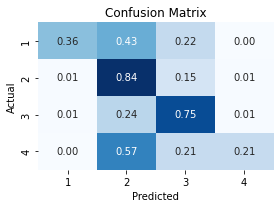

Evaluation completed..
CPU times: total: 47min 45s
Wall time: 36min 36s


In [36]:
%%time
_, feat_importance_xgb2 = train_pipeline(clf=xgb_clf, data=df, ignore_vars=None, ordinal_feats=["Month"], 
                                        test_size=0.3, scoring='f1_weighted', grid_search=True, params=xgb_params, 
                                        sampling_params=sampling_params_xgb, show_cm=True, include_importance=True)

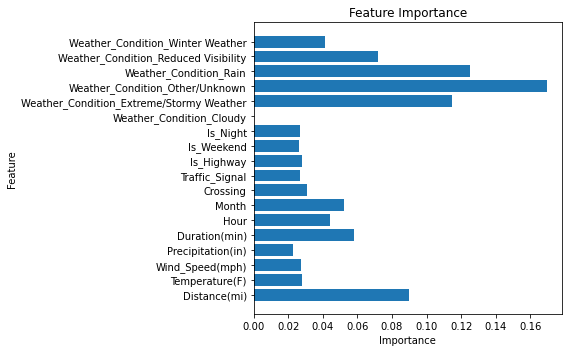

In [37]:
plot_feat_importance(feat_importance_xgb2)

### LightGBM

In [113]:
lgbm_params = {
    'clf__n_estimators': [100, 150, 200],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__min_child_samples': [10, 20, 30],
    'clf__min_split_gain': [0.1, 0.2],
    'clf__subsample': [1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__num_leaves': [50, 100, 150],
}

In [110]:
# Borderline-SMOTE
sampling_params_lgbm = {
    "smote-method": "borderline",
    "sampling_strategy": {0: 0.15, 3: 0.15},
    "downsampling_strategy": {1: 0.5}
}

In [111]:
lgbm_clf = LGBMClassifier(device_type='gpu', verbose=-1)

Resampling with SMOTE..
Training model with GridSearchCV..
Training completed..
Best hyperparameters:
 {'clf__colsample_bytree': 0.6, 'clf__learning_rate': 0.1, 'clf__min_child_samples': 20, 'clf__min_split_gain': 0.1, 'clf__n_estimators': 200, 'clf__num_leaves': 150, 'clf__subsample': 1.0}
Model evaluation..

Train metrics:
Accuracy: 0.852, F1 Score: 0.853, Cohen's Kappa: 0.685

Test metrics:
Accuracy: 0.798, F1 Score: 0.796, Cohen's Kappa: 0.566

Classification report:
              precision    recall  f1-score   support

         0.0       0.37      0.25      0.30       402
         1.0       0.86      0.84      0.85     46218
         2.0       0.69      0.75      0.72     22021
         3.0       0.48      0.19      0.27      1287

    accuracy                           0.80     69928
   macro avg       0.60      0.51      0.53     69928
weighted avg       0.80      0.80      0.80     69928


Confusion matrix:


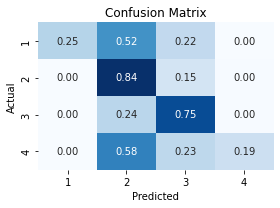

Evaluation completed..
CPU times: total: 44min 23s
Wall time: 7min 39s


In [112]:
%%time
_, feat_importance_lgbm = train_pipeline(clf=lgbm_clf, data=df, ignore_vars=None, ordinal_feats=["Month"], 
                                        test_size=0.3, scoring='f1_weighted', grid_search=True, params=lgbm_params, 
                                        sampling_params=sampling_params_lgbm, show_cm=True, include_importance=True)

### Neural Network (MLP)

In [13]:
def create_mlp_model(input_dim, output_dim, learning_rate=0.001, hid_dim=[128, 64], dropout_rate=0.3):
    model = Sequential()
    # Input layer and first hidden layer
    model.add(Input(shape=(input_dim,)))  # Keep this as the input layer
    model.add(Dense(hid_dim[0], activation='relu'))
    model.add(Dropout(dropout_rate))
    # Second hidden layer
    model.add(Dense(hid_dim[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output layer (assuming multi-class classification)
    model.add(Dense(output_dim, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use built-in accuracy instead of f1
    return model

In [20]:
mlp_params = {
    'clf__hid_dim': [[256, 128]],#[[128, 64], [128, 128], [256, 128], [256, 256]],
    'clf__dropout_rate': [0.2],#[0.2, 0.4, 0.6],
    'clf__learning_rate': [0.0001],#[0.0001, 0.001, 0.01],
    'clf__batch_size': [16],#[16, 32],
    'clf__epochs': [100],
}

In [21]:
# Borderline-SMOTE
sampling_params_mlp = {
    "smote-method": "borderline",
    "sampling_strategy": {0: 0.15, 3: 0.15},
    "downsampling_strategy": {1: 0.5}
}

Resampling with SMOTE..
Training model with GridSearchCV..
Training completed..
Best hyperparameters:
 {'clf__batch_size': 16, 'clf__dropout_rate': 0.2, 'clf__epochs': 100, 'clf__hid_dim': [256, 128], 'clf__learning_rate': 0.0001}
Model evaluation..

Train metrics:
True
Accuracy: 0.757, F1 Score: 0.761, Cohen's Kappa: 0.488

Test metrics:
Accuracy: 0.735, F1 Score: 0.741, Cohen's Kappa: 0.441

Classification report:
              precision    recall  f1-score   support

           0       0.12      0.39      0.18       402
           1       0.82      0.80      0.81     46218
           2       0.65      0.63      0.64     22021
           3       0.15      0.25      0.19      1287

    accuracy                           0.74     69928
   macro avg       0.44      0.52      0.46     69928
weighted avg       0.75      0.74      0.74     69928


Confusion matrix:


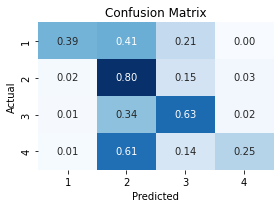

Evaluation completed..
CPU times: total: 17min 35s
Wall time: 2h 16min 58s


In [23]:
%%time
_ = train_pipeline(clf="mlp", build_fn=create_mlp_model, data=df, ignore_vars=None, ordinal_feats=["Month"], 
                                        test_size=0.3, scoring='f1_weighted', grid_search=True, params=mlp_params,
                                        sampling_params=sampling_params_mlp, show_cm=True, include_importance=True)

Resampling with SMOTE..
Training model with GridSearchCV..
Training completed..
Best hyperparameters:
 {'clf__batch_size': 16, 'clf__dropout_rate': 0.2, 'clf__epochs': 50, 'clf__hid_dim': [256, 256], 'clf__learning_rate': 0.0001}
Model evaluation..

Train metrics:
True
Accuracy: 0.755, F1 Score: 0.761, Cohen's Kappa: 0.489

Test metrics:
Accuracy: 0.733, F1 Score: 0.741, Cohen's Kappa: 0.443

Classification report:
              precision    recall  f1-score   support

           0       0.12      0.37      0.19       402
           1       0.82      0.79      0.81     46218
           2       0.65      0.64      0.64     22021
           3       0.16      0.29      0.21      1287

    accuracy                           0.73     69928
   macro avg       0.44      0.52      0.46     69928
weighted avg       0.75      0.73      0.74     69928


Confusion matrix:


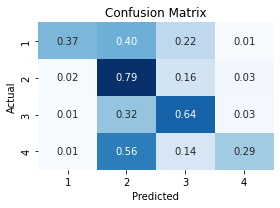

Evaluation completed..
CPU times: total: 30min 35s
Wall time: 2h 37min 38s


In [19]:
%%time
_ = train_pipeline(clf="mlp", build_fn=create_mlp_model, data=df, ignore_vars=None, ordinal_feats=["Month"], 
                                        test_size=0.3, scoring='f1_weighted', grid_search=True, params=mlp_params,
                                        sampling_params=sampling_params_mlp, show_cm=True, include_importance=True)

## Train best model with full dataset

In [43]:
from datetime import datetime
import joblib

In [68]:
params = {
    'learning_rate': 0.1, 
    'max_depth': 10, 
    'n_estimators': 200, 
    'subsample': 0.8, 
    'use_label_encoder': False, 
    'device': 'cuda', 
    'tree_method': 'hist'
}

In [69]:
sampling_params = {
    "smote-method": "borderline",
    "sampling_strategy": {0: 0.15, 3: 0.15},
    "downsampling_strategy": {1: 0.5}
}

In [70]:
clf = xgb.XGBClassifier(**params)

In [71]:
%%time
pipeline = train_pipeline(clf=xgb_clf, data=df, ignore_vars=None, ordinal_feats=["Month"], test_size=0.0, 
                             scoring='f1_weighted', grid_search=False, sampling_params=sampling_params, 
                             show_cm=False, include_importance=False, full_train=True)

Resampling with SMOTE..
Training model..
Training completed..
Model evaluation..

Train metrics:
Accuracy: 0.793, F1 Score: 0.796, Cohen's Kappa: 0.565
CPU times: total: 17.5 s
Wall time: 4.04 s


In [72]:
trained_model = pipeline.named_steps['clf']
preprocessor = pipeline.named_steps['preprocessor']

In [73]:
# Get current timestamp
timestamp = "20241001_144429"#datetime.now().strftime('%Y%m%d_%H%M%S')
# Save the trained pipeline
joblib.dump(trained_model, f'models/xgb_model_{timestamp}.pkl')
joblib.dump(preprocessor, f'models/xgb_preprocessor_{timestamp}.pkl')
print(timestamp)

20241001_144429
